<a href="https://colab.research.google.com/github/VGGatGitHub/QC-Benchmarking/blob/master/max_cut_only_15q_background_results_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modifications and changes to the original IBM QISKit file are indicated with #VGG whenever approprate

The code is best run as a notebook in the IBM Quantum Experince

# Qiskit Aqua: Experimenting with Max-Cut problem with VQE

## Introduction and background informatoin

Many problems in quantitative **fields** such as finance and engineering are optimization problems. Optimization problems lie at the core of complex decision-making and definition of strategies. 

Optimization (or combinatorial optimization) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function. 

**Typical optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects 

We consider here max-cut problems of practical interest in many fields, and show how they can be nmapped on quantum computers.


### Weighted Max-Cut

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other's buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.

The formal definition of this problem is the following:

Consider an $n$-node undirected graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i, j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)

$$\tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

In our simple marketing model, $w_{ij}$ represents the probability that the person $j$ will buy a product after $i$ gets a free one. Note that the weights $w_{ij}$ can in principle be greater than $1$, corresponding to the case where the individual $j$ will buy more than one product. Maximizing the total buying probability corresponds to maximizing the total future revenues. In the case where the profit probability will be greater than the cost of the initial free samples, the strategy is a convenient one. An extension to this model has the nodes themselves carry weights, which can be regarded, in our marketing model, as the likelihood that a person granted with a free sample of the product will buy it again in the future. With this additional information in our model, the objective function to maximize becomes 

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)+\sum_i w_i x_i. $$
 
In order to find a solution to this problem on a quantum computer, one needs first to map it to an Ising Hamiltonian. This can be done with the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_{i,j} \frac{w_{ij}}{4} (1-Z_i)(1+Z_j) + \sum_i \frac{w_i}{2} (1-Z_i) = -\frac{1}{2}\left( \sum_{i<j} w_{ij} Z_i Z_j +\sum_i w_i Z_i\right)+\mathrm{const},$$

where const = $\sum_{i<j}w_{ij}/2+\sum_i w_i/2 $. In other terms, the weighted Max-Cut problem is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

Aqua can generate the Ising Hamiltonian for the first profit function $\tilde{C}$.


### Approximate Universal Quantum Computing for Optimization Problems

There has been a considerable amount of interest in recent times about the use of quantum computers to find a solution to combinatorial problems. It is important to say that, given the classical nature of combinatorial problems, exponential speedup in using quantum computers compared to the best classical algorithms is not guaranteed. However, due to the nature and importance of the target problems, it is worth investigating heuristic approaches on a quantum computer that could indeed speed up some problem instances. Here we demonstrate an approach that is based on the Quantum Approximate Optimization Algorithm by Farhi, Goldstone, and Gutman (2014). We frame the algorithm in the context of *approximate quantum computing*, given its heuristic nature. 

The Algorithm works as follows:
1. Choose the $w_i$ and $w_{ij}$ in the target Ising problem. In principle, even higher powers of Z are allowed.
2. Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
3. Choose a set of controls $\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$. 
4. Evaluate $C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H|~\psi(\boldsymbol\theta)\rangle = \sum_i w_i \langle\psi(\boldsymbol\theta)~|Z_i|~\psi(\boldsymbol\theta)\rangle+ \sum_{i<j} w_{ij} \langle\psi(\boldsymbol\theta)~|Z_iZ_j|~\psi(\boldsymbol\theta)\rangle$ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen. 
5. Use a classical optimizer to choose a new set of controls.
6. Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.
7. Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $|\langle z_i~|\psi(\boldsymbol\theta)\rangle|^2\;\forall i$ to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of an appropriate trial wavefunction. For example, one could consider a trial function whose entanglement best aligns with the target problem, or simply make the amount of entanglement a variable. In this tutorial, we will consider a simple trial function of the form

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of quantum states that have only real coefficients, still exploiting the entanglement to potentially converge faster to the solution.

One advantage of using this sampling method compared to adiabatic approaches is that the target Ising Hamiltonian does not have to be implemented directly on hardware, allowing this algorithm not to be limited to the connectivity of the device. Furthermore, higher-order terms in the cost function, such as $Z_iZ_jZ_k$, can also be sampled efficiently, whereas in adiabatic or annealing approaches they are generally impractical to deal with. 


References:
- A. Lucas, Frontiers in Physics 2, 5 (2014)
- E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028 (2014)
- D. Wecker, M. B. Hastings, M. Troyer Phys. Rev. A 94, 022309 (2016)
- E. Farhi, J. Goldstone, S. Gutmann, H. Neven e-print arXiv 1703.06199 (2017)

#Main Code Cells 

## Import libraries


In [1]:
#%pip uninstall qiskit

In [ ]:
%pip install qiskit==0.16

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [4]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram

#VGG#from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput

from qiskit.optimization.ising import max_cut, tsp
from qiskit.optimization.ising.common import sample_most_likely

from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

In [5]:
#from qiskit import IBMQ
#provider = IBMQ.load_account()

In [6]:
#VGG select the backend for coupling_map
try: 
    backend = provider.get_backend('ibmq_16_melbourne')#'ibmq_16_melbourne')#'ibmq_essex')
    #backend = provider.get_backend('ibmq_london')#'ibmq_16_melbourne')#'ibmq_essex')
except:
    backend = Aer.get_backend('qasm_simulator') #VGG it was 'BasicAer.get_backend' ibmq_16_melbourne
    
coupling_map = backend.configuration().coupling_map
print(coupling_map)

None


# Stting up the code for the Max-Cut problem

### Generate Random Weighted Graph

Given a list of edges, we generate a graph with random edge weights in the range \[-1,1).

In [7]:
from typing import List, Tuple

seed = 19120623
np.random.seed(seed)

#VGG: function adopted from the Rigetti's MaxCutQAOA.ipynb
def generate_ising_graph(edges: List[Tuple[int, int]]) -> nx.Graph:
    graph = nx.from_edgelist(edges)
    weights:  np.ndarray = 2.0 * np.random.rand(graph.number_of_edges()) - 1.0
    weights /= np.linalg.norm(weights)
    nx.set_edge_attributes(graph, {e: {'weight': w} for e, w in zip(graph.edges, weights)})
    return graph

In [8]:
if coupling_map != None:
    G=generate_ising_graph(coupling_map)
    n=G.number_of_nodes()
    print(n)

In [9]:
# Generating a graph if there were no coupling_map
if coupling_map== None:
    #define the edges / coupling_map
    
    #'ibmq_16_melbourne'
    elist=[[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], 
           [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], 
           [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], 
           [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], 
           [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]
    
    elist=[[0,1],[0,2],[0,3],[1,2],[2,3]]

    G=generate_ising_graph(elist)
    n=G.number_of_nodes()
    
#other ways to define the graph   
    #n=5 # Number of nodes in graph
    #G=nx.Graph()
    #G.add_nodes_from(np.arange(0,n,1))
    
    #ewlist=[(0,1,1.),(0,2,.5),(0,3,0),(1,2,1.0),(0,3,1.0)]
    #G1 = nx.from_edgelist(elist)
    #G1.add_weighted_edges_from(ewlist)
    
    


## Visulaize the Graph

4 5


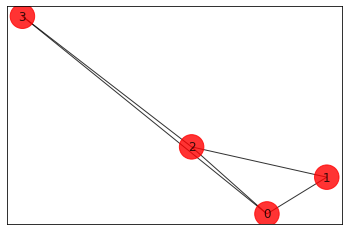

In [10]:
#Visulaize
print(G.number_of_nodes(),G.number_of_edges())
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

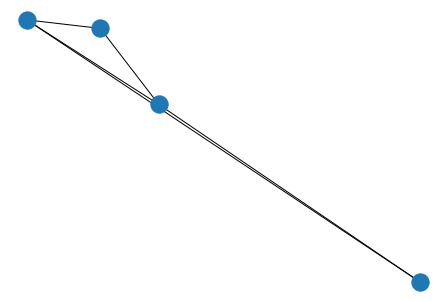

In [11]:
nx.drawing.nx_pylab.draw(G)

##  Pepare for potential export of the graph's weights and edges
G1 = nx.from_edgelist(elist);
G1.add_weighted_edges_from(ewlist)

In [12]:
elist=G.edges()
print("elist=",elist)

elist= [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]


In [13]:
ewlist=[(i,j,G.get_edge_data(i,j,default=0)['weight']) for i,j in G.edges()]
print('ewlist=',ewlist)

ewlist= [(0, 1, 0.47385343962014526), (0, 2, 0.5060071509421842), (0, 3, -0.34853220064443957), (1, 2, 0.6179260784259317), (2, 3, 0.126934422717497)]


In [40]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
w

array([[ 0.        ,  0.47385344,  0.50600715, -0.3485322 ],
       [ 0.47385344,  0.        ,  0.61792608,  0.        ],
       [ 0.50600715,  0.61792608,  0.        ,  0.12693442],
       [-0.3485322 ,  0.        ,  0.12693442,  0.        ]])

In [46]:
np.sum(w)/4

0.6880944455306593

[0,1,1,0]

[1,0,1,0]

[1,1,0,0]

[0,0,0,0]

## Brute force approach to Max-Cut

Try all possible $2^n$ combinations. For $n = 4$, as in this example, one deals with only 16 combinations, but for n = 1000, one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 0.6313283899178899
case = [0, 1, 0, 0] cost = 1.091779518046077
case = [1, 1, 0, 0] cost = 0.7754010287236763
case = [0, 0, 1, 0] cost = 1.250867652085613
case = [1, 0, 1, 0] cost = 0.8701817401191344
case = [0, 1, 1, 0] cost = 1.1067950132798265
case = [1, 1, 1, 0] cost = -0.22159777792694257
case = [0, 0, 0, 1] cost = -0.22159777792694257
case = [1, 0, 0, 1] cost = 1.1067950132798265
case = [0, 1, 0, 1] cost = 0.8701817401191344
case = [1, 1, 0, 1] cost = 1.250867652085613
case = [0, 0, 1, 1] cost = 0.7754010287236763
case = [1, 0, 1, 1] cost = 1.091779518046077
case = [0, 1, 1, 1] cost = 0.6313283899178899
case = [1, 1, 1, 1] cost = 0.0

Best solution = [0, 0, 1, 0] cost = 1.250867652085613


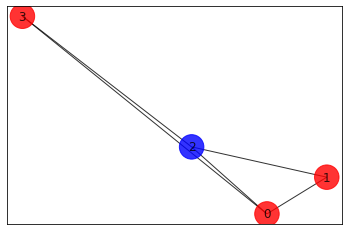

In [41]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    if n < 5:
        print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))    

## Mapping to the Ising problem

In [42]:
#VGG qubitOp, offset = max_cut.get_max_cut_qubitops(w)
qubitOp, offset = max_cut.get_operator(w)
algo_input = EnergyInput(qubitOp)

### Checking that the full Hamiltonian gives the right cost 

energy: -0.5627732065549536 , offset: -0.6880944455306592
max-cut objective: -1.2508676520856128
solution: [1. 1. 0. 1.]
solution objective: 1.250867652085613


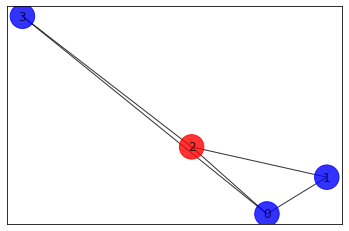

In [44]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

#VGG# x = max_cut.sample_most_likely(result['eigvecs'][0])
x = sample_most_likely(result['eigvecs'][0]) 

print('energy:', result['energy'],', offset:',offset)
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

### [Optional] Using DOcplex for mapping to the Ising problem
Using ```docplex.get_qubitops``` is a different way to create an Ising Hamiltonian of Max-Cut. ```docplex.get_qubitops``` can create a corresponding Ising Hamiltonian from an optimization model of Max-Cut. An example of using ```docplex.get_qubitops``` is as below. 

In [18]:
from docplex.mp.model import Model

#VGG from qiskit.aqua.translators.ising import docplex
from qiskit.optimization.ising import docplex

# Create an instance of a model and variables.
mdl = Model(name='max_cut')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)}

# Object function
max_cut_func = mdl.sum(w[i,j]* x[i] * ( 1 - x[j] ) for i in range(n) for j in range(n))
mdl.maximize(max_cut_func)

# No constraints for Max-Cut problems.

In [19]:
#VGG# qubitOp_docplex, offset_docplex = docplex.get_qubitops(mdl)
qubitOp_docplex, offset_docplex = docplex.get_operator(mdl)

### Checking that the full Hamiltonian made by ```docplex.get_qubitops```  gives the right cost

energy: -0.5627732065549537
max-cut objective: -1.250867652085613
solution: [1. 1. 0. 1.]
solution objective: 1.250867652085613


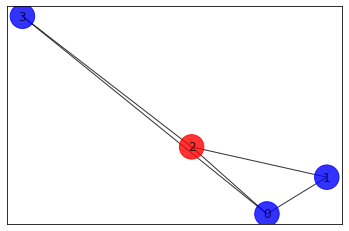

In [20]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp_docplex, k=1)
result = ee.run()

#VGG# x = docplex.sample_most_likely(result['eigvecs'][0])
x = sample_most_likely(result['eigvecs'][0])

print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset_docplex)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

# Running it on a quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

### First some results from runing on few simulater systems 

statevector_simulator
energy: -0.5625736736633661
time: 7.215724229812622
max-cut objective: -1.2506681191940254
solution: [0. 0. 1. 0.]
solution objective: 1.250867652085613


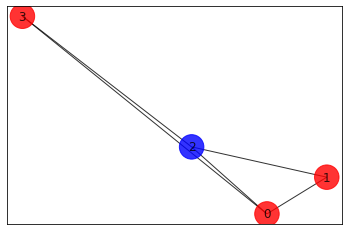

In [21]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend1 = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend1, seed_simulator=seed, seed_transpiler=seed)

print(backend1)
result = vqe.run(quantum_instance)

#VGG# x = max_cut.sample_most_likely(result['eigvecs'][0])
x = sample_most_likely(result['eigvecs'][0])

print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

qasm_simulator
energy: -0.5627732065549536
time: 11.292255163192749
max-cut objective: -1.2508676520856128
solution: [0 0 1 0]
solution objective: 1.250867652085613


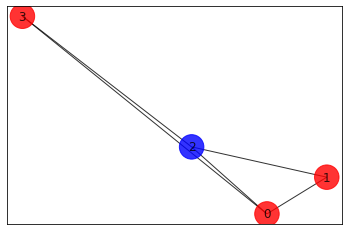

In [22]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend2 = Aer.get_backend('qasm_simulator') #VGG it was 'BasicAer.get_backend' ibmq_16_melbourne
quantum_instance = QuantumInstance(backend2, shots=1024, seed_simulator=seed, seed_transpiler=seed)

print(backend2)
result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

#VGG# x = max_cut.sample_most_likely(result['eigvecs'][0])
x = sample_most_likely(result['eigvecs'][0])

print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

## Results from runing on the IBMQ system 

In [23]:
backend

<QasmSimulator('qasm_simulator') from AerProvider()>

In [24]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=30) #VGG 300
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

#backend = provider.get_backend('ibmq_16_melbourne')#'ibmq_16_melbourne')#'ibmq_essex' # ibmq_london
#backend = provider.get_backend('ibmq_qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

print("submiting for results using:",backend)
result = vqe.run(quantum_instance)


submiting for results using: qasm_simulator


qasm_simulator
energy: -0.24100796442908784
time: 1.4028325080871582
max-cut objective: -0.9291024099597471
solution: [0 1 0 1]
solution objective: 0.8701817401191344


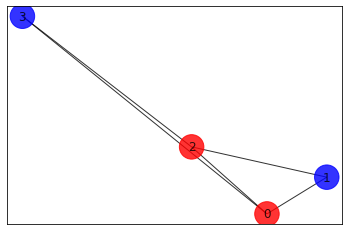

In [25]:
#VGG# x = max_cut.sample_most_likely(result['eigvecs'][0])
x = sample_most_likely(result['eigvecs'][0])

print(backend)
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)



# **Acknowlegments**


In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright